In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from model import SIRModel

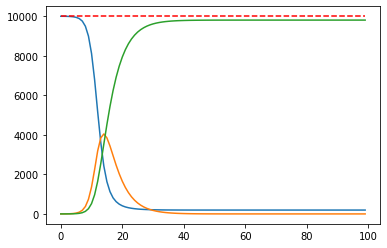

In [4]:
BETA=1.0
GAMMA=1/4
model=SIRModel(beta=BETA,gamma=GAMMA)
t=np.arange(0,100)
S0=10000
I0=1
R0=0
y_0=[S0,I0,R0]
y_t=model.predict(t,y_0)

plt.plot(t,y_t[0])
plt.plot(t,y_t[1])
plt.plot(t,y_t[2])
plt.plot(t,y_t[0]+y_t[1]+y_t[2],"r--")
plt.show()

In [5]:
model.beta_=0.90
model.gamma_=0.22
N=S0+I0
I=y_t[1]
R0=y_t[2][0]
model.fit(t,N,I)

In [6]:
param_names=("BETA","GAMMA")
true_parms=(BETA,GAMMA)
for i, (p,true_p, name) in enumerate(zip(model.params,true_parms,param_names)):
    print( f"true value {name} = {true_p} ~ {p}  +/- {np.sqrt(model.params_cov_[i,i])}")

true value BETA = 1.0 ~ 0.9999999999999999  +/- 5.20812747154914e-17
true value GAMMA = 0.25 ~ 0.24999999999999997  +/- 3.927352897294046e-17


# Fit model à un jeu de donnée

(array([737492., 737499., 737506., 737516., 737523., 737530., 737537.,
        737546.]),
 <a list of 8 Text major ticklabel objects>)

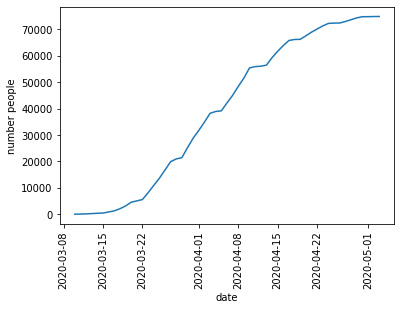

In [8]:
#chargement et transformation des données 

data_dir = 'data'

#Load data
tests_depistage_latest = pd.read_csv(os.path.join(data_dir, 'donnees-tests-covid19-labo-quotidien-2020-05-06-19h00.csv'),
                             sep=';')

hospital_latest = pd.read_csv(os.path.join(data_dir, 'donnees-hospitalieres-covid19-2020-05-05-19h00.csv'),
                              sep=';')

tests_depistage_latest['jour'] =  pd.to_datetime(tests_depistage_latest['jour'], format='%Y-%m-%d')
aggr_tests_latest=tests_depistage_latest.groupby(['jour']).sum()
aggr_tests_latest['nb_pos']=aggr_tests_latest['nb_pos'].cumsum()

hospital_latest['jour'] =  pd.to_datetime(hospital_latest['jour'], format='%Y-%m-%d')
aggr_hospital_latest=hospital_latest.groupby(['jour']).sum()
aggr_hospital_latest['rad']=aggr_hospital_latest['rad'].cumsum()

plt.plot(aggr_tests_latest['nb_pos'])
plt.ylabel('number people')
plt.xlabel('date')
plt.xticks(rotation=90)

0.6015794872043967
0.3644279953472897


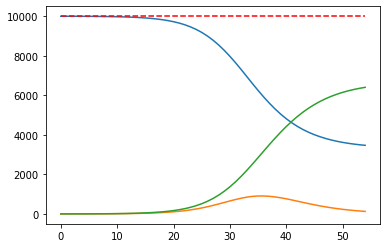

In [9]:
BETA=1.0
GAMMA=1/4
model=SIRModel(beta=BETA,gamma=GAMMA)

#adapter t à l'intervalle de nos données 
delta=aggr_tests_latest.index.max()-aggr_tests_latest.index.min()
t=np.arange(0,aggr_tests_latest.shape[0])

N=1000000 #population en France

I=aggr_tests_latest['nb_pos']

model.fit(t,N,I)
print(model.beta_)
print(model.gamma_)
y_t=model.predict(t,y_0)

plt.plot(t,y_t[0])
plt.plot(t,y_t[1])
plt.plot(t,y_t[2])
plt.plot(t,y_t[0]+y_t[1]+y_t[2],"r--")
plt.show()